# ECSE 275 Assignment 5 Part 3

In this google colab notebook, we train a neural network to recognize numbers. We will later use this trained neural network to imbue a robot with the ability to recognize numbers.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

def visualize_mnist_grid(data_loader, num_samples=25, num_rows=5):
    # Create an iterator from the data loader
    data_iterator = iter(data_loader)

    # Get a batch of images and labels
    images, labels = next(data_iterator)

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_samples // num_rows, figsize=(12, 8))

    for i in range(num_samples):
        row, col = i // (num_samples // num_rows), i % (num_samples // num_rows)
        ax = axes[row, col]
        image = images[i].numpy().squeeze()
        label = labels[i].item()

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()


In [40]:
# Run this to use GPU
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


We will use the MNIST data set of numbers. We load the dataset for use and visualize it to give us an idea of what we are dealing with.

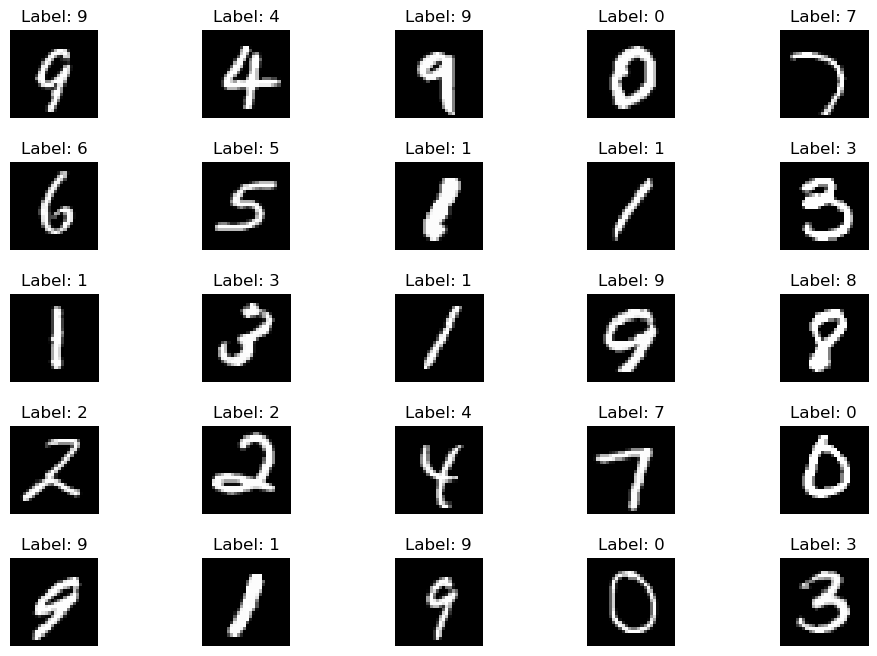

In [41]:
#transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(size=(24, 24))])
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize a grid of 25 samples from the MNIST dataset
visualize_mnist_grid(trainloader, num_samples=25, num_rows=5)

## Question 2: Fully Connected Neural Network

Define a neural network architecture with 3 Linear Layers

Use the following intermediate layer architecture:

1.   First Layer 128 nodes
2.   Second Layer 64 nodes

**What dimension is input to the first layer if we are going to flatten the image into a single vector?**

**What should the output be if we are trying to predict 10 different numbers with the softmax function?**

Do build the network you have to construct a custom `Net` class which inherits from the `nn.Module` class

During the `init` method use the function to declare layers: `nn.Linear(input_dim,output_dim)`

In the `forward` method, pass the input through each layer by calling the layers in sequence.
e.g `x = self.fc(x) `

After each pass through an intermediate layer, remember to then pass the network through a non-linearity. Here we use the Rectified Linear Unit
e.g. `x = F.relu(x)`

The output of the last layer does not need to be pass through a non-linearity
Just return the value of x after we pass all the layers.


In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x) # Linear Layer ReLU
        x = self.fc2(x) # Linear Layer ReLU
        x = self.fc3(x) # Linear Layer
        return x

net = Net().to(device)
net


Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Define the loss criteria and our optimization method

The loss we use is the Cross Entropy Loss. This automatically uses the Softmax function followed by calculation of the negative log-likelihood loss.

For the optimizer, we use the Ada-M AKA Adam optimizer because it does not require us to really tune the learning rate for our training.

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train the neural network

We will run the neural network training for 10 passes (epochs) through our data.

We monitor the loss over each epoch

In [44]:
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

Epoch 1, Loss: 0.38797826427958415
Epoch 2, Loss: 0.29779024656488695
Epoch 3, Loss: 0.28764476753405926
Epoch 4, Loss: 0.2812587862520584
Epoch 5, Loss: 0.27738806714555986
Epoch 6, Loss: 0.27484972268215885
Epoch 7, Loss: 0.2720085308154318
Epoch 8, Loss: 0.2702503606343447
Epoch 9, Loss: 0.26730780776089696
Epoch 10, Loss: 0.2658986694165575


### Evaluate our performance on the test dataset

Next, we create a new dataloader for the MNIST Test Set and run an evaluation of our trained neural network.

**Report your accuracy on the test set.**

In [45]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 92.24%


### Save our model parameters

We can save our model parameters to a specific file name.

Make sure to save these weights to your local drive.

In [46]:
filename = "model_weights.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)

## Question 3: Train a Convolutional Neural Network

Next we will train a more powerful model for image recognition, the convolutional neural network.

We will use the following architecture

1.   Convolution Layer 32-channel with stride 5
2.   Maxpool kernel size 2, stride 2
3.   Convolution Layer 64-channel with stride 3
4.   Maxpool kernel size 2, stride 2
5.   Convolution Layer 64-channel with stride 1
6.   Maxpool kernel size 2, stride 2
7.   Linear Layer 128 nodes

After each neural network layer (i.e. convolutional linear layers) we must pass the output through a Rectified Linear Unit like we did in with the fully connected neural network in Question 2.

Convolutional layers can be defined using `nn.Conv2d(input_channel,output_channel,stride)`

Maxpools can be performed using `nn.MaxPool2d(kernel size,stride)`

**What is the final size of the output of the final pool layer? Note: This is the input size to the first linear layer**

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 128, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 64, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.conv1(x)) # Conv ReLU Pool
        x = self.pool2(self.conv2(x)) # Conv ReLU Pool
        x = self.pool3(self.conv3(x)) # Conv ReLU Pool
        x = x.view(-1, 256)
        x = self.fc1(x) # ReLU Linear Layer
        x = self.fc2(x) # Linear Layer
        return x


try:
  del net
  del loss
except:
  pass

torch.cuda.empty_cache()
net = CNN().to(device)

net

CNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Define the loss criteria and our optimization method
The loss we use is the Cross Entropy Loss. This automatically uses the Softmax function followed by calculation of the negative log-likelihood loss.

For the optimizer, we use the Ada-M AKA Adam optimizer because it does not require us to really tune the learning rate for our training.

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train the neural network

We will run the neural network training for 10 passes (epochs) through our data.

We monitor the loss over each epoch

In [49]:
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

Epoch 1, Loss: 0.15079424911831965
Epoch 2, Loss: 0.059201212174423944
Epoch 3, Loss: 0.048162599265577144
Epoch 4, Loss: 0.03762705669406854
Epoch 5, Loss: 0.034791335459063655
Epoch 6, Loss: 0.02954783278243855
Epoch 7, Loss: 0.026793546673905162
Epoch 8, Loss: 0.02686387544863542
Epoch 9, Loss: 0.025343207893893376
Epoch 10, Loss: 0.022086240700414678


### Evaluate our performance on the test dataset

Next, we create a new dataloader for the MNIST Test Set and run an evaluation of our trained neural network.

**Report your accuracy on the test set**

In [50]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 98.34%


### Save our model parameters

We can save our model parameters to a specific file name.

Make sure to save these weights to your local drive.

In [51]:
filename = "model_weights_cnn.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)

## Question 4: Train with data augmentation

Finally we train a Convolutional Neural Network, but this time we create variation in our training data using data augmentation.

We will use a crop augmentation which will randomly crop the training images and rescale them so that the neural network is resistant to scale changes in the numbers.

Below we declare and then visualize the augmented dataset.

/Users/ariglockner/miniconda3/envs/CSDS275-Robotics/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


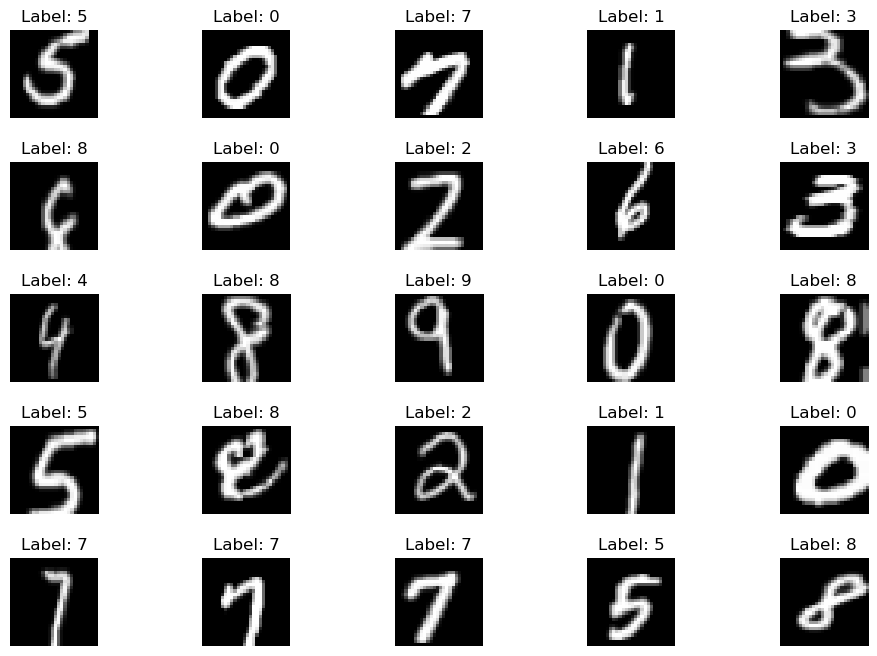

In [52]:
transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(size=(28, 28),scale=(0.4,1.0))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize a grid of 25 samples from the MNIST dataset
visualize_mnist_grid(trainloader, num_samples=25, num_rows=5)

### Train and Evaluation

We go through the training process using the same convolutional network architecture we used in Question 3.

**Report the accuracy on the test set.**

**Compared to the previous networks, how is the accuracy different? Why do you think this is so?**

In [53]:
# Re-declare the CNN object, the loss, and the optimizer
try:
  del net
  del loss
except:
  pass

torch.cuda.empty_cache()
net = CNN()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Run the training
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluate on the test set
transform = transforms.Compose([transforms.ToTensor()]) # remove the data augmentation transformation
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Epoch 1, Loss: 0.5563655660938479
Epoch 2, Loss: 0.31893918908703556
Epoch 3, Loss: 0.2666966618060557
Epoch 4, Loss: 0.24309944611654352
Epoch 5, Loss: 0.22982954585563337
Epoch 6, Loss: 0.21310820793117413
Epoch 7, Loss: 0.20527613573054324
Epoch 8, Loss: 0.19995170758207087
Epoch 9, Loss: 0.19187722145728686
Epoch 10, Loss: 0.18389208227801107
Accuracy on the test set: 97.78%


### Save the model

We can save our model parameters to a specific file name.

Make sure to save these weights to your local drive.

In [54]:
filename = "model_weights_cnn_aug.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)